This jupyter file is to plot figures for dynamic-TIM-task performance paper

In [ ]:
'''
this part is to plot the dynamics of the spnc model
'''


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')

import spnc_ml as ml
from spnc import spnc_anisotropy


In [3]:
# set up a spnc instance
Nvirt = 30
h = 0.4
theta_H = 90
k_s_0 = 0
phi = 45
beta_prime = 20
params = {'theta': 0.113,'gamma' : 0,'delay_feedback' : 0,'Nvirt' : Nvirt}
spn = spnc_anisotropy(h,theta_H,k_s_0,phi,beta_prime)
transform = spn.gen_signal_slow_delayed_feedback



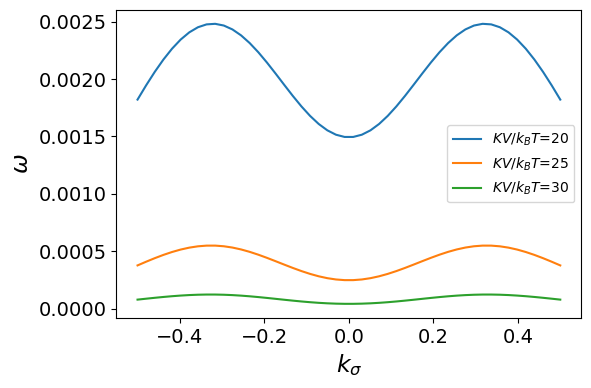

In [11]:
klist = np.linspace(-0.5, 0.5)
bp_list = [20,25,30]

plt.figure(figsize=(6,4))

for i in bp_list:
    omega_list = []
    beta_prime = i

    for j in klist:
        k_s = j
        spnc = spnc_anisotropy(0.4, 90, k_s, 45, beta_prime)
        omega_list.append(spnc.get_omega_prime())

    plt.plot(klist, omega_list, label=f'$KV/k_BT$={i}')

plt.xlabel(r'$k_\sigma$',fontsize = 17)
plt.ylabel(r'$\omega$',fontsize = 17)
# plt.yscale('log')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize = 10)
plt.show()


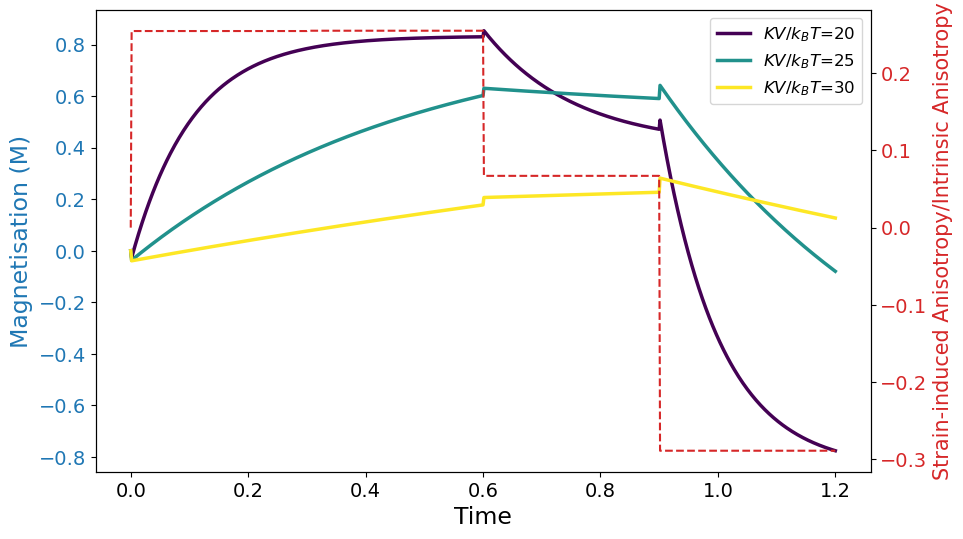

In [14]:
def plot_magnetic_properties(beta_primes):
    klist = np.random.uniform(-0.4, 0.4, 4)
    density = 200
    theta = 0.3
    beta_cons = 25

    # 自动生成颜色和标签
    colors = plt.cm.viridis(np.linspace(0, 1, len(beta_primes)))
    labels = [f'$KV/k_BT$={beta_prime}' for beta_prime in beta_primes]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    for beta_prime, color, label in zip(beta_primes, colors, labels):
        spnc = spnc_anisotropy(0.4, 90, 0, 45, beta_prime)
        params = {
            'theta': 0.3,
            'gamma': 0,
            'beta_prime': beta_prime,
            'delay_feedback': 0,
            'Nvirt': 400 if beta_prime != 20 else 40
        }
        K_s, thetas, mags = spnc.gen_trace_slow_delayed_feedback_omegacons(klist, theta, density, params, beta_cons)
        ax1.plot(thetas, mags, label=label, color=color, linewidth=2.5)
        if beta_prime == 20:
            K_s_main = K_s

    ax1.set_xlabel('Time', fontsize=17)
    ax1.set_ylabel('Magnetisation (M)', color='tab:blue', fontsize=17)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    plt.legend(fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(thetas, K_s_main, label='k', color='tab:red', linestyle='--')
    ax2.set_ylabel('Strain-induced Anisotropy/Intrinsic Anisotropy', color='tab:red', fontsize=15)
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)

   
    plt.show()

# 调用函数并传递参数
beta_primes = [20,25,30]
plot_magnetic_properties(beta_primes)

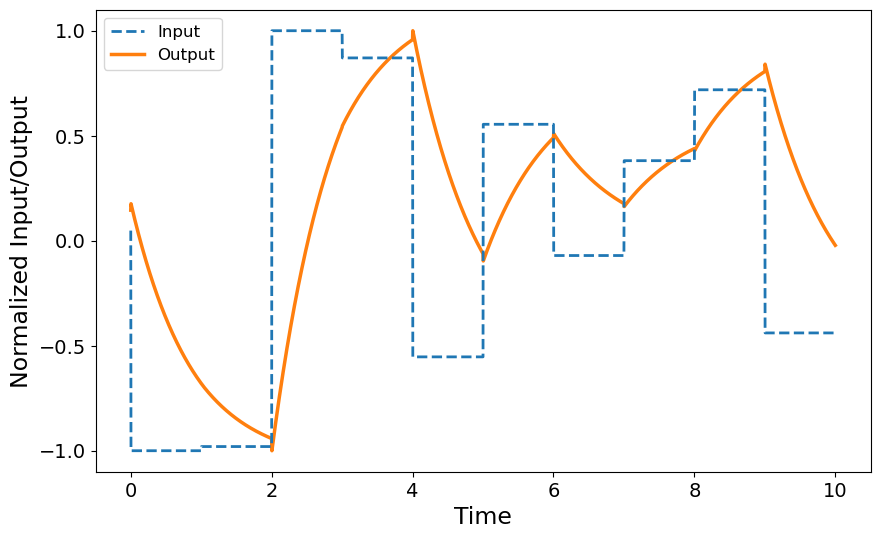

In [60]:
def plot_nonlinearity_fadingmemory(beta_primes):
    klist = np.random.uniform(-0.1, 0.1, 10)
    density = 300
    theta = 1
    beta_cons = 20

    # 自动生成颜色和标签
    colors = ['tab:orange']
    labels = [f'$KV/k_BT$={beta_prime}' for beta_prime in beta_primes]

    fig, ax = plt.subplots(figsize=(10, 6))

    # 定义标准化函数，将数据缩放到[-1, 1]范围
    def normalize_to_range(data, target_min=-1, target_max=1):
        data_min = np.min(data)
        data_max = np.max(data)
        if data_max == data_min:  # 避免除零错误
            return np.zeros_like(data)
        normalized = (data - data_min) / (data_max - data_min)  # 先标准化到[0, 1]
        return normalized * (target_max - target_min) + target_min  # 然后缩放到[target_min, target_max]

    for beta_prime, color, label in zip(beta_primes, colors, labels):
        spnc = spnc_anisotropy(0.4, 90, 0, 45, beta_prime)
        params = {
            'theta': 0.3,
            'gamma': 0,
            'beta_prime': beta_prime,
            'delay_feedback': 0,
            'Nvirt': 400 if beta_prime != 20 else 40
        }
        K_s, thetas, mags = spnc.gen_trace_slow_delayed_feedback_omegacons(klist, theta, density, params, beta_cons)
        
        # 标准化输出数据到[-1, 1]范围
        mags_normalized = normalize_to_range(mags)
        
        ax.plot(thetas, mags_normalized, label=f'Output', color=color, linewidth=2.5)
        if beta_prime == 20:
            K_s_main = K_s

    # 标准化输入数据到[-1, 1]范围
    K_s_main_normalized = normalize_to_range(K_s_main)
    
    # 在同一个轴上绘制输入数据
    ax.plot(thetas, K_s_main_normalized, label='Input', color='tab:blue', linestyle='--', linewidth=2)

    ax.set_xlabel('Time', fontsize=17)
    ax.set_ylabel('Normalized Input/Output', fontsize=17)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    # 设置y轴刻度为-1, -0.5, 0, 0.5, 1
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])

    # 先获取所有图例句柄和标签
    handles, labels = ax.get_legend_handles_labels()
    # 按照要求调整顺序：先input再output
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: 0 if x[1] == 'Input' else 1)
    handles_sorted, labels_sorted = zip(*sorted_handles_labels)
    ax.legend(handles_sorted, labels_sorted, fontsize=12)

    plt.show()

# 调用函数并传递参数
beta_primes = [20]
plot_nonlinearity_fadingmemory(beta_primes)